<a href="https://colab.research.google.com/github/Alf-caput/NonVerbalAudioClassifier/blob/dev2/src/Conv1D_85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip

--2024-04-25 15:39:15--  https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fuld3z222j9t1oy/vs_release_16k.zip [following]
--2024-04-25 15:39:16--  https://www.dropbox.com/s/raw/fuld3z222j9t1oy/vs_release_16k.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0f331021168e4737b33c0387b8.dl.dropboxusercontent.com/cd/0/inline/CRumjmB0Fy0z6NxbhqbthBMldfQW3yNhAgTBplvzEGE0NQ-Tjx5B-8D9d3RuKLcIu96zRAGUPaPTRgVf8pcW63vtDUbfc7PCNXKhSdhJwU-DhUfRjAt_zjJyvYu8hqme2bjlssaxv6968JaeoJS6n8jg/file# [following]
--2024-04-25 15:39:17--  https://uc0f331021168e4737b33c0387b8.dl.dropboxusercontent.com/cd/0/inline/CRumjmB0Fy0z6NxbhqbthBMldfQW3yNhAgTBplvzEGE0NQ-Tjx5B-8D9d3RuKLcIu96zRAGUPaPTRgVf8

In [2]:
import os

zip_filename = 'vs_release_16k.zip'

if not os.path.exists(zip_filename):
    os.system("wget https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip")

Dentro de vs_release_16k.zip descomprimimos:  
- audio_16k  

Nos servimos del módulo zipfile para descomprimir.  

In [3]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

zip_filename = 'vs_release_16k.zip'
audio_dir = 'audio_16k/'

if not os.path.exists(audio_dir):
    with ZipFile(zip_filename, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if file.startswith(audio_dir):
                    exe.submit(zf.extract, file)

In [4]:
import tensorflow as tf

audio_dir = 'audio_16k/'
seed = 42

tf.random.set_seed(seed)

ds_files = tf.data.Dataset.list_files(audio_dir + '*.wav') # by default shuffle=True

print("Total audios:", len(ds_files))
print("Filenames shape:", ds_files.element_spec)

Total audios: 21024
Filenames shape: TensorSpec(shape=(), dtype=tf.string, name=None)


In [5]:
for elem in ds_files.take(5):
    print(elem)

tf.Tensor(b'audio_16k/f0228_0_sneeze.wav', shape=(), dtype=string)
tf.Tensor(b'audio_16k/f0496_0_sneeze.wav', shape=(), dtype=string)
tf.Tensor(b'audio_16k/m1948_1_cough.wav', shape=(), dtype=string)
tf.Tensor(b'audio_16k/m1478_0_cough.wav', shape=(), dtype=string)
tf.Tensor(b'audio_16k/m1513_0_cough.wav', shape=(), dtype=string)


In [6]:
vocal_sounds = ['cough', 'laughter', 'sigh', 'sneeze', 'sniff', 'throatclearing']
num_sounds = len(vocal_sounds)

for elem in ds_files.take(1):
    example_file = elem

def get_label(file_path):
  label = tf.strings.split(
    input=file_path,
    sep='_')[-1]

  label = tf.strings.split(
    input=label,
    sep='.')[0]

  label = tf.where(label==vocal_sounds)
  label = tf.reshape(label, ())
  return label

print("Filename Tensor:", example_file)
print("Label Tensor:", get_label(example_file))

Filename Tensor: tf.Tensor(b'audio_16k/m2844_0_sigh.wav', shape=(), dtype=string)
Label Tensor: tf.Tensor(2, shape=(), dtype=int64)


In [7]:
for elem in ds_files.take(1):
    example_file = elem

def get_signal(file_path):

  audio_binary = tf.io.read_file(file_path)
  signal = tf.audio.decode_wav(audio_binary)[0]

  return tf.squeeze(signal, axis=-1)

print("Filename Tensor:", example_file)
print("Signal Tensor:", get_signal(example_file))

Filename Tensor: tf.Tensor(b'audio_16k/f1334_0_laughter.wav', shape=(), dtype=string)
Signal Tensor: tf.Tensor(
[ 3.3569336e-03  4.2419434e-03  1.2207031e-03 ...  9.1552734e-05
  0.0000000e+00 -1.8310547e-04], shape=(94208,), dtype=float32)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

ds_signals = (
    ds_files
    .shuffle(len(ds_files))
    .cache()
    .map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)
    )

print("Total signals:", len(ds_signals))
print("Signals shape:", ds_signals.element_spec)

Total signals: 21024
Signals shape: (TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


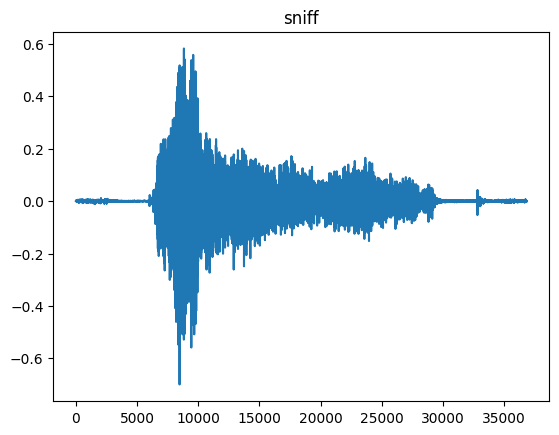

In [9]:
import matplotlib.pyplot as plt
for elem in ds_signals.take(1):
  signal, label = elem
  plt.plot(signal)
  plt.title(vocal_sounds[label])

In [10]:
for elem in ds_files:
  print(get_signal(elem).shape[0])
  break

17749


In [11]:
ds_files = tf.data.Dataset.list_files(audio_dir + '*.wav') # by default shuffle=True
len(ds_files)

21024

In [12]:
def remove_shortaudio(file_path, min_len):
  if get_signal(file_path).shape[0] < min_len:
    tf.io.gfile.remove(file_path)

initial_file_count = 21024

if len(ds_files) >= initial_file_count:
  # Remove less than 0.1s audios (16kHz then 1600 frames)
  min_len = 1600
  with ThreadPoolExecutor() as exe:
    for file in ds_files:
      exe.submit(remove_shortaudio, file.numpy(), min_len)

  ds_files = tf.data.Dataset.list_files(audio_dir + '*.wav') # by default shuffle=True

print('Total audios:', len(ds_files))

Total audios: 20982


In [13]:
ds_signals = ds_files.map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)
for elem in ds_signals.take(1):
  print(elem)

(<tf.Tensor: shape=(68267,), dtype=float32, numpy=
array([ 5.1879883e-04,  9.7656250e-04,  8.2397461e-04, ...,
       -2.1362305e-04, -6.1035156e-05,  6.1035156e-05], dtype=float32)>, <tf.Tensor: shape=(), dtype=int64, numpy=5>)


In [14]:
vocal_sounds = ['cough', 'laughter', 'sigh', 'sneeze', 'sniff', 'throatclearing']
num_sounds = len(vocal_sounds)


def normalize(signal, label):
  # Label to onehot
  label = tf.one_hot(label, len(vocal_sounds))

  # Signal to standard length
  std_len = 64_000 # 4s
  curr_len = len(signal)
  print(curr_len, len(signal))

  if curr_len > std_len:
    rand_idx = tf.random.uniform(shape=[], maxval=curr_len-std_len, dtype=tf.int32)
    signal = signal[rand_idx:rand_idx+std_len]

  else:
    left_padding = (std_len - curr_len) // 2
    right_padding = std_len - curr_len - left_padding
    signal = tf.pad(signal, [[left_padding, right_padding]])

  return signal, label

ds_signals = ds_signals.map(normalize)

Tensor("strided_slice:0", shape=(), dtype=int32) Tensor("strided_slice_1:0", shape=(), dtype=int32)


In [15]:
for elem in ds_signals.take(2):
  print(elem)

(<tf.Tensor: shape=(64000,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0.], dtype=float32)>)
(<tf.Tensor: shape=(64000,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0.], dtype=float32)>)


In [16]:
ds_signals.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(6,), dtype=tf.float32, name=None))

In [17]:
num_train = len(ds_signals)

RATIO = 0.2
test_size = int(RATIO * num_train)

ds_train = ds_signals.skip(test_size)
ds_test = ds_signals.take(test_size)

In [18]:
num_train = len(ds_train)

RATIO = 0.2
validation_size = int(RATIO * num_train)

ds_fit = ds_signals.skip(validation_size)
ds_val = ds_signals.take(validation_size)

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128
ds_fit = (
    ds_fit
    .cache()
    .shuffle(len(ds_fit))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val
    .cache()
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.0001)

epoch_wait = 5
# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=epoch_wait, restore_best_weights=True)

# Definimos los callbacks
callbacks = [early_stopping, reduce_lr]

In [23]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(64000, 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(6),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(3),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(4),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),

    Dense(64, activation='relu'),
    Dense(6, activation='softmax')  # Usar softmax para clasificación multiclase
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 63998, 64)         256       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 31999, 64)         0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 31997, 64)         12352     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 5332, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 5330, 64)          12352     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 1776, 64)         

In [24]:
history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

Epoch 1/100
138/138 [==============================] - 96s 671ms/step - loss: 0.4237 - accuracy: 0.3213 - val_loss: 0.3401 - val_accuracy: 0.5338 - lr: 0.0010
Epoch 2/100
138/138 [==============================] - 96s 693ms/step - loss: 0.3041 - accuracy: 0.6025 - val_loss: 0.2651 - val_accuracy: 0.6807 - lr: 0.0010
Epoch 3/100
138/138 [==============================] - 92s 666ms/step - loss: 0.2473 - accuracy: 0.7017 - val_loss: 0.2489 - val_accuracy: 0.6905 - lr: 0.0010
Epoch 4/100
138/138 [==============================] - 92s 667ms/step - loss: 0.2131 - accuracy: 0.7490 - val_loss: 0.2020 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 5/100
138/138 [==============================] - 95s 691ms/step - loss: 0.1853 - accuracy: 0.7881 - val_loss: 0.1942 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 6/100
138/138 [==============================] - 92s 667ms/step - loss: 0.1602 - accuracy: 0.8199 - val_loss: 0.1718 - val_accuracy: 0.8180 - lr: 0.0010
Epoch 7/100
138/138 [=========================

In [25]:
BATCH_SIZE = 128
ds_eval = (
    ds_test.cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_loss, test_acc = model.evaluate(ds_eval)

print('Test accuracy:', test_acc)

33/33 [==============================] - 14s 421ms/step - loss: 0.1554 - accuracy: 0.8532
Test accuracy: 0.8531935214996338


In [32]:
# model.save_weights('testnn')
model.save('Conv1D_85')

In [33]:
# Create a new model instance
mymodel = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(64000, 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(6),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(3),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(4),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),

    Dense(64, activation='relu'),
    Dense(6, activation='softmax')  # Usar softmax para clasificación multiclase
])

mymodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Restore the weights
mymodel.load_weights('Conv1D_82')

BATCH_SIZE = 128
ds_eval = (
    ds_test.cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_loss, test_acc = mymodel.evaluate(ds_eval)

print('Test accuracy:', test_acc)

33/33 [==============================] - 14s 392ms/step - loss: 0.1635 - accuracy: 0.8510
Test accuracy: 0.8510485887527466


In [29]:
!zip -r Conv1D_82.zip Conv1D_82

  adding: Conv1D_82/ (stored 0%)
  adding: Conv1D_82/keras_metadata.pb (deflated 94%)
  adding: Conv1D_82/assets/ (stored 0%)
  adding: Conv1D_82/saved_model.pb (deflated 89%)
  adding: Conv1D_82/variables/ (stored 0%)
  adding: Conv1D_82/variables/variables.index (deflated 67%)
  adding: Conv1D_82/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: Conv1D_82/fingerprint.pb (stored 0%)
